In [307]:
#try 64 inputs with a lower LR?

Let's start from scratch.  Don't forget to run the cells at the bottom.  Check that you have added in Chase's modification to the ECF calculation.

Outline:

- Setup the data
- Check the impact of only using 32 constituents on the jet mass
- Train a classifier (FCN) on the full 32 constituents and compare with D2 and jet mass
- FGSM the networks from the previous step
- Check the performance after the adversarial attack
- Check the impact of reordering
- Try a PFN on the 32 constituents, which is robust to reording

In [1]:
#First, let's setup the GPU.

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [235]:
#Now, many includes

import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
from keras.utils import to_categorical
from sklearn.metrics import roc_curve
from sklearn import preprocessing
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd
import itertools as it #needed for ECF calculation

In [4]:
#Now, for the data

d_big = pd.DataFrame(np.load('../events_small.npy'))
d_big.shape

(800000, 2101)

In [5]:
# masks for bg and signal events
is_bg = (d_big[2100] == 0)
is_sig = (d_big[2100] == 1)

print("N_bg  = %d"%np.sum(is_bg))
print("N_sig = %d"%np.sum(is_sig))
print("N_tot = %d"%(np.sum(is_bg) + np.sum(is_sig)))

N_bg  = 727279
N_sig = 72721
N_tot = 800000


In [6]:
#Now, we need to put the data in a good format for later processing.

hold = np.array(d_big)
sig = [hold[i,:][:-1].reshape(700,3) for i in range(len(hold)) if hold[i,:][-1]==1]
bg = [hold[i,:][:-1].reshape(700,3) for i in range(len(hold)) if hold[i,:][-1]==0]

In [8]:
# cluster jets, requiring pT>1.6 TeV
ntrk = 32
pt_min = 1600

bg_jets, bg_consts = cluster_jets(bg, ntrk=ntrk, pt_min=pt_min)
sig_jets, sig_consts = cluster_jets(sig, ntrk=ntrk, pt_min=pt_min)

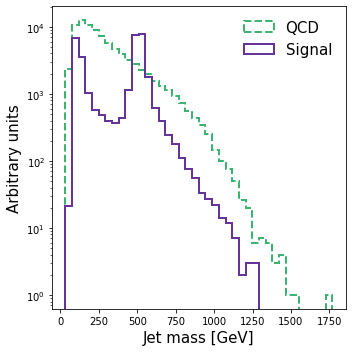

In [9]:
fig = plt.figure(figsize=(5,5))
n,b,_=plt.hist(bg_jets[:,3], histtype='step', bins=40, label=['QCD'],color='mediumseagreen',linestyle='--',linewidth=2.0)
plt.hist(sig_jets[:,3], histtype='step', bins=b, label=['Signal'],color='rebeccapurple',linewidth=2.0)
plt.yscale('log');
plt.xlabel("Jet mass [GeV]",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.legend(fontsize=15,frameon=False);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
fig.savefig("mJ.pdf");

In [67]:
# Format the dataset for input to the NN.
# First stack to together data from the two classes

nsig = len(sig_consts)
nbg = len(bg_consts)
ncls = min(nsig, nbg)

X = np.concatenate([bg_consts[:ncls], sig_consts[:ncls]], axis=0).copy()
X_monly = np.concatenate([bg_jets[:,3][:ncls], sig_jets[:,3][:ncls]], axis=0).copy()

# convert pT units to TeV (to limit range of inputs to NN)
X[:,:,0] /= 1000.
X_monly /= 1000.

# make labels for bg (=0) and signal(=1)
y = np.zeros(X.shape[0], dtype=int)
y[ncls:] = 1

# randomly assign 85% of data to training sample, reserve the rest for validation
is_train = np.random.rand(X.shape[0])<0.85

X_train = X[is_train]
X_monly_train = X_monly[is_train]
y_train = y[is_train]

X_val = X[~is_train]
X_monly_val = X_monly[~is_train]
y_val = y[~is_train]

Now, let's calculate the jet mass from the 32-constituent jets.  The first thing we should do is see how much information is lost from only usingn such jets.

In [86]:
ecf1_train = ecf_numpy(1, 1, X_train, normalized=False)
ecf2_train = ecf_numpy(2, 1, X_train, normalized=False) + K.epsilon()
ecf3_train = ecf_numpy(3, 1, X_train, normalized=False)

ecf1_val = ecf_numpy(1, 1, X_val, normalized=False)
ecf2_val = ecf_numpy(2, 1, X_val, normalized=False) + K.epsilon()
ecf3_val = ecf_numpy(3, 1, X_val, normalized=False)

In [133]:
d2_train = ecf3_train * pow(ecf1_train, 3) / pow(ecf2_train, 3)
d2_val = ecf3_val * pow(ecf1_val, 3) / pow(ecf2_val, 3)

m_train = mymass_numpy(X_train)[:,0]
m_val = mymass_numpy(X_val)[:,0]

combined_train = np.array([[d2_train[i],m_train[i]] for i in range(len(d2_train))])
combined_val = np.array([[d2_val[i],m_val[i]] for i in range(len(d2_val))])

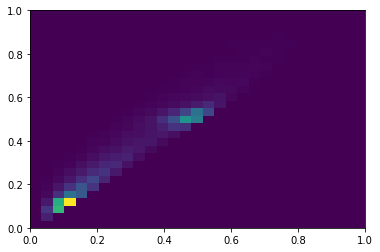

In [51]:
_,_,_,_=plt.hist2d(m_train[:,0],X_monly_train,bins=(np.linspace(0,1,30),np.linspace(0,1,30)))

In [134]:
Nepochs = 100

mass32_net = vanillaNN('mass32_net',1)
mass32_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
his_mass32 = mass32_net.fit(m_train, to_categorical(y_train,2), epochs=Nepochs, batch_size=128,validation_data=(m_val, to_categorical(y_val,2)))

mass_net = vanillaNN('mass_net',1)
mass_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
his_mass = mass_net.fit(X_monly_train, to_categorical(y_train,2), epochs=Nepochs, batch_size=128 ,validation_data=(X_monly_val, to_categorical(y_val,2)))

Dtwo32_net = vanillaNN('Dtwo32_net',1)
Dtwo32_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
his_Dtwo32 = Dtwo32_net.fit(d2_train, to_categorical(y_train,2), epochs=Nepochs, batch_size=128,validation_data=(d2_val, to_categorical(y_val,2)))

D2andmass32_net = vanillaNN('D2andmass32_net',2)
D2andmass32_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
his_D2andmass32 = D2andmass32_net.fit(combined_train, to_categorical(y_train,2), epochs=Nepochs, batch_size=128,validation_data=(combined_val, to_categorical(y_val,2)))

Train on 57225 samples, validate on 9951 samples
Epoch 1/100
57225/57225 [==============================] - 4s 74us/step - loss: 0.5966 - acc: 0.6996 - val_loss: 0.5769 - val_acc: 0.7205
Epoch 2/100
57225/57225 [==============================] - 2s 34us/step - loss: 0.5665 - acc: 0.7184 - val_loss: 0.5441 - val_acc: 0.7276
Epoch 3/100
57225/57225 [==============================] - 2s 34us/step - loss: 0.5323 - acc: 0.7400 - val_loss: 0.5040 - val_acc: 0.7591
Epoch 4/100
57225/57225 [==============================] - 2s 34us/step - loss: 0.5042 - acc: 0.7661 - val_loss: 0.4875 - val_acc: 0.7778
Epoch 5/100
57225/57225 [==============================] - 2s 33us/step - loss: 0.4882 - acc: 0.7774 - val_loss: 0.4771 - val_acc: 0.7808
Epoch 6/100
57225/57225 [==============================] - 2s 33us/step - loss: 0.4806 - acc: 0.7825 - val_loss: 0.4703 - val_acc: 0.7834
Epoch 7/100
57225/57225 [==============================] - 2s 34us/step - loss: 0.4735 - acc: 0.7872 - val_loss: 0.4651 - v

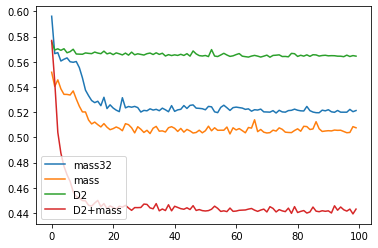

In [135]:
plt.plot(his_mass32.history['val_loss'],label='mass32')
plt.plot(his_mass.history['val_loss'],label='mass')
plt.plot(his_Dtwo32.history['val_loss'],label='D2')
plt.plot(his_D2andmass32.history['val_loss'],label='D2+mass')
plt.legend()

In [136]:
preds_mass32 = mass32_net.predict(m_val)
fpr_mass32, tpr_mass32, _ = roc_curve(y_val, 1-preds_mass32[:,1])

preds_mass = mass_net.predict(X_monly_val)
fpr_mass, tpr_mass, _ = roc_curve(y_val, 1-preds_mass[:,1])

preds_Dtwo32 = Dtwo32_net.predict(d2_val)
fpr_Dtwo32, tpr_Dtwo32, _ = roc_curve(y_val, 1-preds_Dtwo32[:,1])

preds_D2andmass32 = D2andmass32_net.predict(combined_val)
fpr_D2andmass32, tpr_D2andmass32, _ = roc_curve(y_val, 1-preds_D2andmass32[:,1])

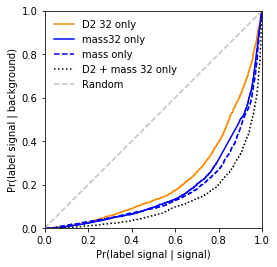

In [139]:
plt.axes().set_aspect('equal')
plt.plot(fpr_Dtwo32,tpr_Dtwo32,color='darkorange',label=r'D2 32 only')
plt.plot(fpr_mass32,tpr_mass32,color='blue',label=r'mass32 only')
plt.plot(fpr_mass,tpr_mass,color='blue',label=r'mass only',linestyle="--")
plt.plot(fpr_D2andmass32,tpr_D2andmass32,color='black',label=r'D2 + mass 32 only',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False)
plt.show()

In [192]:
#Now, FCN on all the inputs.

#model_32_NN = Sequential()
#model_32_NN.add(Dense(64, activation='relu',input_shape=(32,3)))
#model_32_NN.add(Flatten())
#model_32_NN.add(layers.Dropout(0.4))
#model_32_NN.add(Dense(128, activation='relu'))
#model_32_NN.add(layers.Dropout(0.4))
#model_32_NN.add(Dense(128, activation='relu')) #new
#model_32_NN.add(layers.Dropout(0.4))
#model_32_NN.add(Dense(2, activation='softmax'))

classifier_input = layers.Input((32,3))
    
H = classifier_input

H = layers.Flatten()(H)

for _ in range(2):
    H = layers.Dense(128, activation='relu')(H)
    H = layers.Dropout(0.25)(H)

H = layers.Dense(2, activation='softmax')(H)

model_32_NN = Model(classifier_input, H)
model_32_NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 3)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 128)               12416     
_________________________________________________________________
dropout_90 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_91 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 2)                 258       
Total para

In [218]:
lr = 2e-4
model_32_NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
K.set_value(model_32_NN.optimizer.lr, lr)
his_NN32 = model_32_NN.fit(X_train, to_categorical(y_train,2), epochs=100, batch_size=128,validation_data=(X_val, to_categorical(y_val,2)))

Train on 57225 samples, validate on 9951 samples
Epoch 1/100
57225/57225 [==============================] - 8s 135us/step - loss: 0.4717 - acc: 0.7744 - val_loss: 0.5197 - val_acc: 0.7441
Epoch 2/100
57225/57225 [==============================] - 4s 64us/step - loss: 0.4681 - acc: 0.7778 - val_loss: 0.5263 - val_acc: 0.7427
Epoch 3/100
57225/57225 [==============================] - 4s 64us/step - loss: 0.4713 - acc: 0.7745 - val_loss: 0.5185 - val_acc: 0.7445
Epoch 4/100
57225/57225 [==============================] - 4s 67us/step - loss: 0.4700 - acc: 0.7764 - val_loss: 0.5163 - val_acc: 0.7465
Epoch 5/100
57225/57225 [==============================] - 4s 65us/step - loss: 0.4687 - acc: 0.7764 - val_loss: 0.5198 - val_acc: 0.7453
Epoch 6/100
57225/57225 [==============================] - 4s 74us/step - loss: 0.4725 - acc: 0.7743 - val_loss: 0.5263 - val_acc: 0.7407
Epoch 7/100
57225/57225 [==============================] - 4s 75us/step - loss: 0.4720 - acc: 0.7735 - val_loss: 0.5179 - 

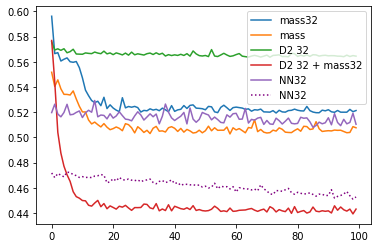

In [219]:
plt.plot(his_mass32.history['val_loss'],label='mass32')
plt.plot(his_mass.history['val_loss'],label='mass')
plt.plot(his_Dtwo32.history['val_loss'],label='D2 32')
plt.plot(his_D2andmass32.history['val_loss'],label='D2 32 + mass32')
plt.plot(his_NN32.history['val_loss'],label='NN32')
plt.plot(his_NN32.history['loss'],label='NN32',color='purple',linestyle=":")
plt.legend()

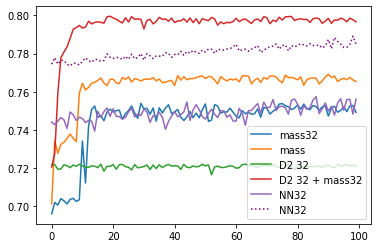

In [220]:
plt.plot(his_mass32.history['val_acc'],label='mass32')
plt.plot(his_mass.history['val_acc'],label='mass')
plt.plot(his_Dtwo32.history['val_acc'],label='D2 32')
plt.plot(his_D2andmass32.history['val_acc'],label='D2 32 + mass32')
plt.plot(his_NN32.history['val_acc'],label='NN32')
plt.plot(his_NN32.history['acc'],label='NN32',color='purple',linestyle=":")
plt.legend()

In [221]:
preds_NN = model_32_NN.predict(X_val)
fpr_NN, tpr_NN, _ = roc_curve(y_val, 1-preds_NN[:,1])

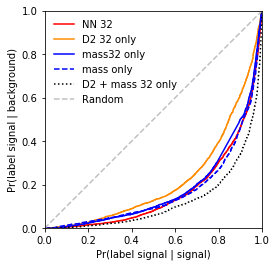

In [319]:
plt.axes().set_aspect('equal')
plt.plot(fpr_NN,tpr_NN,color='red',label=r'NN 32')
plt.plot(fpr_Dtwo32,tpr_Dtwo32,color='darkorange',label=r'D2 32 only')
plt.plot(fpr_mass32,tpr_mass32,color='blue',label=r'mass32 only')
plt.plot(fpr_mass,tpr_mass,color='blue',label=r'mass only',linestyle="--")
plt.plot(fpr_D2andmass32,tpr_D2andmass32,color='black',label=r'D2 + mass 32 only',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False)
plt.show()

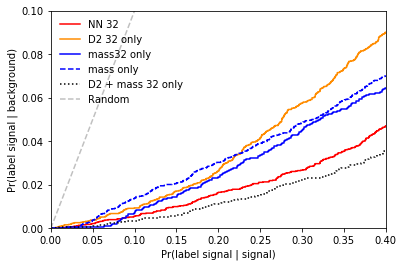

In [304]:
#plt.axes().set_aspect('equal')
plt.plot(fpr_NN,tpr_NN,color='red',label=r'NN 32')
plt.plot(fpr_Dtwo32,tpr_Dtwo32,color='darkorange',label=r'D2 32 only')
plt.plot(fpr_mass32,tpr_mass32,color='blue',label=r'mass32 only')
plt.plot(fpr_mass,tpr_mass,color='blue',label=r'mass only',linestyle="--")
plt.plot(fpr_D2andmass32,tpr_D2andmass32,color='black',label=r'D2 + mass 32 only',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 0.4, 0, 0.1])
plt.legend(loc='upper left',frameon=False)
plt.show()

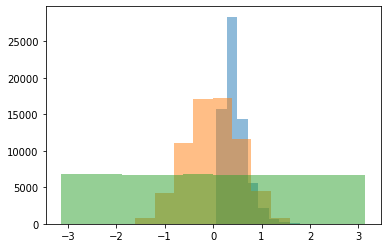

In [233]:
_,_,_=plt.hist(X[:,:,0][:,0],alpha=0.5)
_,_,_=plt.hist(X[:,:,1][:,0],alpha=0.5)
_,_,_=plt.hist(X[:,:,2][:,0],alpha=0.5)

In [249]:
#Let's try standardizing.

X_norm = X
mean = np.mean(np.array(X[:,:,0]).flatten())
std = np.std(np.array(X[:,:,0]).flatten())
X_norm[:,:,0] = (X_norm[:,:,0]-mean)/std

mean = np.mean(np.array(X[:,:,1]).flatten())
std = np.std(np.array(X[:,:,1]).flatten())
X_norm[:,:,1] = (X_norm[:,:,1]-mean)/std

mean = np.mean(np.array(X[:,:,2]).flatten())
std = np.std(np.array(X[:,:,2]).flatten())
X_norm[:,:,2] = (X_norm[:,:,2]-mean)/std

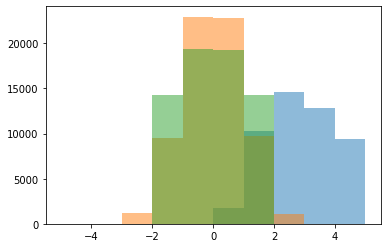

In [251]:
_,b,_=plt.hist(X_norm[:,:,0][:,0],alpha=0.5,range=(-5,5),bins=10)
_,_,_=plt.hist(X_norm[:,:,1][:,0],alpha=0.5,bins=b)
_,_,_=plt.hist(X_norm[:,:,2][:,0],alpha=0.5,bins=b)

In [252]:
X_norm_train = X_norm[is_train]
X_norm_val = X_norm[~is_train]

In [278]:
classifier_input = layers.Input((32,3))
    
H = classifier_input

H = layers.Flatten()(H)

for _ in range(2):
    H = layers.Dense(64, activation='relu')(H)
    H = layers.Dropout(0.3)(H)

H = layers.Dense(2, activation='softmax')(H)

model_32_NN_norm = Model(classifier_input, H)

In [285]:
lr = 2e-4
model_32_NN_norm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
K.set_value(model_32_NN_norm.optimizer.lr, lr)
his_NN32_norm = model_32_NN_norm.fit(X_norm_train, to_categorical(y_train,2), epochs=200, batch_size=128,validation_data=(X_norm_val, to_categorical(y_val,2)),shuffle=True)

Train on 57225 samples, validate on 9951 samples
Epoch 1/200
57225/57225 [==============================] - 7s 122us/step - loss: 0.4768 - acc: 0.7734 - val_loss: 0.5046 - val_acc: 0.7625
Epoch 2/200
57225/57225 [==============================] - 2s 42us/step - loss: 0.4747 - acc: 0.7747 - val_loss: 0.5025 - val_acc: 0.7656
Epoch 3/200
57225/57225 [==============================] - 2s 42us/step - loss: 0.4760 - acc: 0.7742 - val_loss: 0.5035 - val_acc: 0.7619
Epoch 4/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4744 - acc: 0.7750 - val_loss: 0.5058 - val_acc: 0.7598
Epoch 5/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4755 - acc: 0.7730 - val_loss: 0.5016 - val_acc: 0.7639
Epoch 6/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4760 - acc: 0.7736 - val_loss: 0.5040 - val_acc: 0.7644
Epoch 7/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4757 - acc: 0.7742 - val_loss: 0.5019 - 

57225/57225 [==============================] - 2s 41us/step - loss: 0.4699 - acc: 0.7758 - val_loss: 0.5017 - val_acc: 0.7645
Epoch 62/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4716 - acc: 0.7763 - val_loss: 0.5012 - val_acc: 0.7642
Epoch 63/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4718 - acc: 0.7772 - val_loss: 0.4989 - val_acc: 0.7644
Epoch 64/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4702 - acc: 0.7769 - val_loss: 0.5033 - val_acc: 0.7645
Epoch 65/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4711 - acc: 0.7762 - val_loss: 0.5015 - val_acc: 0.7636
Epoch 66/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4725 - acc: 0.7770 - val_loss: 0.5034 - val_acc: 0.7644
Epoch 67/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4713 - acc: 0.7750 - val_loss: 0.5038 - val_acc: 0.7619
Epoch 68/200
57225/57225 [==============

Epoch 120/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4698 - acc: 0.7764 - val_loss: 0.5002 - val_acc: 0.7625
Epoch 121/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4680 - acc: 0.7781 - val_loss: 0.5015 - val_acc: 0.7649
Epoch 122/200
57225/57225 [==============================] - 2s 42us/step - loss: 0.4683 - acc: 0.7786 - val_loss: 0.5016 - val_acc: 0.7646
Epoch 123/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4686 - acc: 0.7775 - val_loss: 0.5061 - val_acc: 0.7600
Epoch 124/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4665 - acc: 0.7813 - val_loss: 0.5036 - val_acc: 0.7631
Epoch 125/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4713 - acc: 0.7766 - val_loss: 0.5000 - val_acc: 0.7656
Epoch 126/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4712 - acc: 0.7775 - val_loss: 0.5058 - val_acc: 0.7617
Epoch 127/200
57225/

57225/57225 [==============================] - 2s 41us/step - loss: 0.4671 - acc: 0.7789 - val_loss: 0.5036 - val_acc: 0.7641
Epoch 179/200
57225/57225 [==============================] - 2s 40us/step - loss: 0.4646 - acc: 0.7812 - val_loss: 0.5036 - val_acc: 0.7644
Epoch 180/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4671 - acc: 0.7793 - val_loss: 0.5021 - val_acc: 0.7650
Epoch 181/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4680 - acc: 0.7785 - val_loss: 0.5006 - val_acc: 0.7662
Epoch 182/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4663 - acc: 0.7798 - val_loss: 0.5013 - val_acc: 0.7669
Epoch 183/200
57225/57225 [==============================] - 2s 42us/step - loss: 0.4662 - acc: 0.7803 - val_loss: 0.5010 - val_acc: 0.7655
Epoch 184/200
57225/57225 [==============================] - 2s 41us/step - loss: 0.4669 - acc: 0.7796 - val_loss: 0.5008 - val_acc: 0.7647
Epoch 185/200
57225/57225 [=======

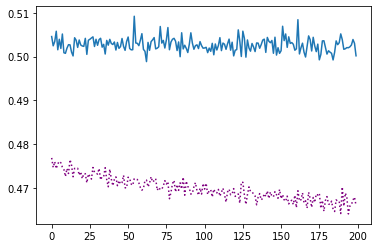

In [286]:
plt.plot(his_NN32_norm.history['val_loss'],label='NN32')
plt.plot(his_NN32_norm.history['loss'],label='NN32',color='purple',linestyle=":")

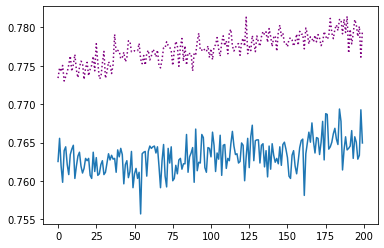

In [305]:
plt.plot(his_NN32_norm.history['val_acc'],label='NN32')
plt.plot(his_NN32_norm.history['acc'],label='NN32',color='purple',linestyle=":")

In [290]:
preds_NN_norm = model_32_NN_norm.predict(X_norm_val)
fpr_NN_norm, tpr_NN_norm, _ = roc_curve(y_val, 1-preds_NN_norm[:,1])

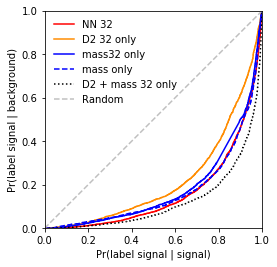

In [291]:
plt.axes().set_aspect('equal')
plt.plot(fpr_NN_norm,tpr_NN_norm,color='red',label=r'NN 32')
plt.plot(fpr_Dtwo32,tpr_Dtwo32,color='darkorange',label=r'D2 32 only')
plt.plot(fpr_mass32,tpr_mass32,color='blue',label=r'mass32 only')
plt.plot(fpr_mass,tpr_mass,color='blue',label=r'mass only',linestyle="--")
plt.plot(fpr_D2andmass32,tpr_D2andmass32,color='black',label=r'D2 + mass 32 only',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False)
plt.show()

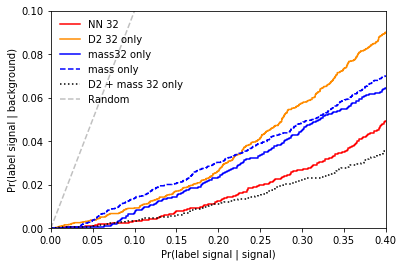

In [296]:
#plt.axes().set_aspect('equal')
plt.plot(fpr_NN_norm,tpr_NN_norm,color='red',label=r'NN 32')
plt.plot(fpr_Dtwo32,tpr_Dtwo32,color='darkorange',label=r'D2 32 only')
plt.plot(fpr_mass32,tpr_mass32,color='blue',label=r'mass32 only')
plt.plot(fpr_mass,tpr_mass,color='blue',label=r'mass only',linestyle="--")
plt.plot(fpr_D2andmass32,tpr_D2andmass32,color='black',label=r'D2 + mass 32 only',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 0.4, 0, 0.1])
plt.legend(loc='upper left',frameon=False)
plt.show()

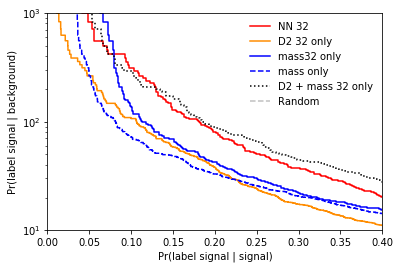

In [303]:
#plt.axes().set_aspect('equal')
plt.plot(fpr_NN_norm,1./(0.00001+tpr_NN_norm),color='red',label=r'NN 32')
plt.plot(fpr_Dtwo32,1./(0.00001+tpr_Dtwo32),color='darkorange',label=r'D2 32 only')
plt.plot(fpr_mass32,1./(0.00001+tpr_mass32),color='blue',label=r'mass32 only')
plt.plot(fpr_mass,1./(0.00001+tpr_mass),color='blue',label=r'mass only',linestyle="--")
plt.plot(fpr_D2andmass32,1./(0.00001+tpr_D2andmass32),color='black',label=r'D2 + mass 32 only',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 0.4, 10, 1000])
plt.legend(loc='upper right',frameon=False)
plt.yscale("log")
plt.show()

Now let's try FGSM

In [308]:
# pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

njet = 6000
target_class = 0

use_sign = True

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x_NN = X_val[y_val==target_class][:njet]
x_adv_NN = x_NN.copy()
x_noise_NN = np.zeros_like(x_NN)

prediction_history_NN     = [model_32_NN.predict(x_NN)[:,target_class].mean()]
prediction_history_quant_NN = [np.percentile(model_32_NN.predict(x_NN)[:,target_class],100*np.array([0.5,0.68,0.95]))]

In [310]:
epsilons = (2e-4,2e-3,2e-3)
nstep = 10

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), model_32_NN.get_output_at(0))
    grads = K.gradients(loss, model_32_NN.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise_NN = x_noise_NN + delta
    
    x_adv_NN = x_adv_NN + epsilon*delta
    x_adv_NN = sess.run(x_adv_NN, feed_dict={model_32_NN.get_input_at(0):x_NN})
    preds = model_32_NN.predict(x_adv_NN)[:,target_class]
    prediction_history_NN.append(preds.mean())
    prediction_history_quant_NN.append(np.percentile(preds, 100*np.array([0.5,0.68,0.9])))
    print("  avg:", preds.mean())

FGSM 1/10...
  avg: 0.61950666
FGSM 2/10...
  avg: 0.5918168
FGSM 3/10...
  avg: 0.5651329
FGSM 4/10...
  avg: 0.5393914
FGSM 5/10...
  avg: 0.5146784
FGSM 6/10...
  avg: 0.49102336
FGSM 7/10...
  avg: 0.4683099
FGSM 8/10...
  avg: 0.4464989
FGSM 9/10...
  avg: 0.4255644
FGSM 10/10...
  avg: 0.40554374


In [320]:
preds_NN_adv = model_32_NN.predict(x_adv_NN)
fprNN_adv, tprNN_adv, _ = roc_curve(np.concatenate([y_val[y_val!=target_class],np.zeros(len(preds_NN_adv))]),np.concatenate([1-preds_NN[y_val!=target_class][:,1],1-preds_NN_adv[:,1]]))

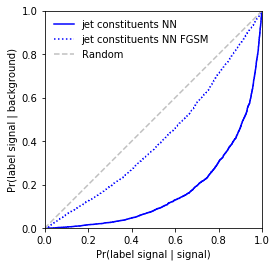

In [321]:
plt.axes().set_aspect('equal')
plt.plot(fpr_NN,tpr_NN,color='blue',label=r'jet constituents NN')
plt.plot(fprNN_adv,tprNN_adv,color='blue',label=r'jet constituents NN FGSM',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False)
plt.show()

In [322]:
pT,eta,phi=np.split(x_adv_NN,3,axis=2)
pT0,eta0,phi0=np.split(x_NN,3,axis=2)

In [323]:
pTdiff = pT-pT0

In [326]:
pT[0]

array([[0.30145353],
       [0.18614367],
       [0.16141719],
       [0.12742643],
       [0.11164882],
       [0.09908027],
       [0.08939644],
       [0.07201073],
       [0.0610401 ],
       [0.05403112],
       [0.0362834 ],
       [0.03084948],
       [0.03419792],
       [0.02447932],
       [0.02803035],
       [0.0204029 ],
       [0.01538044],
       [0.01888601],
       [0.01857172],
       [0.0184402 ],
       [0.0162891 ],
       [0.01512696],
       [0.01466303],
       [0.01391037],
       [0.01344967],
       [0.01275972],
       [0.00766728],
       [0.00721475],
       [0.00649516],
       [0.00595253],
       [0.00534029],
       [0.0046389 ]], dtype=float32)

In [330]:
eta_sorted = [x for _,x in sorted(zip(pT[0],eta[0]))]
eta_sorted = eta_sorted[::-1]

In [331]:
for i in range(len(eta_sorted)):
    print(i,eta_sorted[i],eta[0][i],pT[0][i])

0 [1.0946229] [1.0946229] [0.30145353]
1 [1.1020733] [1.1020733] [0.18614367]
2 [1.1030676] [1.1030676] [0.16141719]
3 [1.0527493] [1.0527493] [0.12742643]
4 [1.0583937] [1.0583937] [0.11164882]
5 [1.1064391] [1.1064391] [0.09908027]
6 [1.1028457] [1.1028457] [0.08939644]
7 [1.0515082] [1.0515082] [0.07201073]
8 [1.0626417] [1.0626417] [0.0610401]
9 [1.0563222] [1.0563222] [0.05403112]
10 [1.0904206] [1.0904206] [0.0362834]
11 [1.1176443] [1.0644003] [0.03084948]
12 [1.0644003] [1.1176443] [0.03419792]
13 [1.0579798] [1.0600256] [0.02447932]
14 [1.0600256] [1.0579798] [0.02803035]
15 [1.0975] [1.0975] [0.0204029]
16 [1.0943543] [1.138171] [0.01538044]
17 [1.1686441] [1.0943543] [0.01888601]
18 [1.1185507] [1.1686441] [0.01857172]
19 [1.0874078] [1.1185507] [0.0184402]
20 [1.138171] [1.0874078] [0.0162891]
21 [1.090988] [1.090988] [0.01512696]
22 [1.0935278] [1.0935278] [0.01466303]
23 [1.0904063] [1.0904063] [0.01391037]
24 [1.1049113] [1.1049113] [0.01344967]
25 [1.0927687] [1.0927687

In [343]:
x_adv_NN_resorted = []
for i in range(len(x_adv_NN)):
    pT_sorted = [x for _,x in sorted(zip(pT[i],pT[i]))]
    pT_sorted = pT_sorted[::-1]
    
    eta_sorted = [x for _,x in sorted(zip(pT[i],eta[i]))]
    eta_sorted = eta_sorted[::-1]
    
    phi_sorted = [x for _,x in sorted(zip(pT[i],phi[i]))]
    phi_sorted = phi_sorted[::-1]
    
    hold_combo = np.concatenate([pT_sorted,eta_sorted,phi_sorted],axis=1)
    
    x_adv_NN_resorted+=[hold_combo]
    pass

In [344]:
x_adv_NN_resorted = np.array(x_adv_NN_resorted)
pT_re,eta_re,phi_re=np.split(x_adv_NN_resorted,3,axis=2)

In [347]:
preds_NN_adv_re = model_32_NN.predict(x_adv_NN_resorted)
fprNN_adv_re, tprNN_adv_re, _ = roc_curve(np.concatenate([y_val[y_val!=target_class],np.zeros(len(preds_NN_adv_re))]),np.concatenate([1-preds_NN[y_val!=target_class][:,1],1-preds_NN_adv_re[:,1]]))

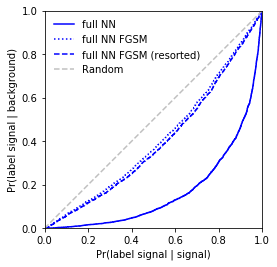

In [351]:
plt.axes().set_aspect('equal')
plt.plot(fpr_NN,tpr_NN,color='blue',label=r'full NN')
plt.plot(fprNN_adv,tprNN_adv,color='blue',label=r'full NN FGSM',linestyle=":")
plt.plot(fprNN_adv_re,tprNN_adv_re,color='blue',label=r'full NN FGSM (resorted)',linestyle="--")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False)
plt.show()

I like having all the functions readily available in one file when debugging things.  Everything below here are functions that we will be using above, down here to remove clutter.  Need to come down here and run all the cells before the ones above.

In [7]:
# Takes an input of shape (Nevt, Nparticle, 3), and returns a tuple (jets, consts):
# `jets` is a list containing the (pt, eta, phi, m) for the leading jet in each event
# `consts` is a list containing the (pt, eta, phi) for the leading `ntrk` particles in the jet.

def cluster_jets(evts, ntrk=16, pt_min=1600, gev=False, ntrk_min=None):
    ljets = np.zeros((len(evts), 4))
    consts = np.zeros((len(evts), ntrk, 3))
    
    if ntrk_min is None:
        ntrk_min = ntrk
    
    unit = 1e3 if gev else 1.0
    
    arr = np.zeros(700, dtype=DTYPE_PTEPM)
    for i,evt in enumerate(evts):
        pt = evt[:,0]
        mask = pt>0
        n = np.sum(mask)
        pt = pt[mask]
        eta = evt[:,1][mask]
        phi = evt[:,2][mask]
        pj_input = arr[:n]
        pj_input['pT'] = pt*unit
        pj_input['eta'] = eta
        pj_input['phi'] = phi
        sequence = cluster(pj_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)

        if len(jets) < 1:
            continue
        
        j0 = jets[0]
        
        
        c0 = j0.constituents_array()
        c0[::-1].sort()
        nc = min(c0.shape[0], ntrk)
        
        if c0.shape[0] < ntrk_min:
            continue
            
        ljets[i] = (j0.pt, j0.eta, j0.phi, j0.mass)
        
        consts[i][:nc,0] = c0[:nc]['pT']
        consts[i][:nc,1] = c0[:nc]['eta']
        consts[i][:nc,2] = c0[:nc]['phi']
        
    sel = ljets[:,0] > pt_min
    ljets = ljets[sel]
    consts = consts[sel]
    
    return ljets, consts

In [31]:
def mymass_tensorflow(x):
    #this one takes _consts without any modification.
    pT,eta,phi=tf.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = K.sum(pT*tf.cos(phi),axis=1)
    jpy = K.sum(pT*tf.sin(phi),axis=1)
    jpz = K.sum(pT*(0.5*(tf.exp(eta)-tf.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = K.sum(pT*(0.5*(tf.exp(eta)+tf.exp(-eta))),axis=1) #no tf.cosh in my version
    jet_m2 = jpE**2-jpx**2-jpy**2-jpz**2
    jet_mass = K.sqrt(K.where(jet_m2>0,jet_m2,K.zeros_like(jet_m2))) #m
    return jet_mass #m
def mymass_numpy(x):
    #this one takes _consts without any modification.
    pT,eta,phi=np.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = np.sum(pT*np.cos(phi),axis=1)
    jpy = np.sum(pT*np.sin(phi),axis=1)
    jpz = np.sum(pT*(0.5*(np.exp(eta)-np.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = np.sum(pT*(0.5*(np.exp(eta)+np.exp(-eta))),axis=1) #no tf.cosh in my version
    jet_m2 = jpE**2-jpx**2-jpy**2-jpz**2
    jet_mass = np.sqrt(np.where(jet_m2>0,jet_m2,np.zeros_like(jet_m2))) #m
    return jet_mass #m

In [14]:
def ecf_numpy(N, beta, x, normalized=False):
    pt = x[:,:,0]
    eta = x[:,:,1:2]
    phi = x[:,:,2:]

    if N == 0:
        return np.ones(x.shape[0])
    elif N == 1:
        if normalized:
            return np.ones(x.shape[0])
        else:
            return np.sum(pt, axis=-1)
    
    # pre-compute the R_ij matrix
    R = np.concatenate([np.sqrt((eta[:,i:i+1]-eta)**2+(phi[:,i:i+1]-phi)**2) for i in range(x.shape[1])], axis=-1)
    # note, if dR = 0, these are either diagonal or padded entries that will get killed by pT=0 terms.
    # set these entries to some positive number to avoid divide-by-zero when beta<0
    R = np.clip(R, 1e-6, 999)
    
    # and raise it to the beta power for use in the product expression
    R_beta = R**beta
    
    # indexing tensor, returns 1 if i>j>k...
    eps = np.zeros((x.shape[1],)*N)
    for idx in it.combinations(range(x.shape[1]), r=N):
        eps[idx] = 1
        
    if N == 2:
        result = np.einsum('ij,...i,...j,...ij',eps,pt,pt,R_beta)
    elif N == 3:
        result =  np.einsum('ijk,...i,...j,...k,...ij,...ik,...jk',eps,pt,pt,pt,R_beta,R_beta,R_beta)
    else:
        # just for fun, the general case...
        # use ascii chars a...z for einsum indices
        letters = [chr(asc) for asc in range(97,97+N)]
        idx_expression = ''.join(letters) +',' + ','.join('...%s'%c for c in letters)
        for a,b in it.combinations(letters, r=2):
            idx_expression += ',...%s%s'%(a,b)
        #print(idx_expression)
        args = (eps,) + (pt,)*N + (R_beta,)*(N*(N-1)//2)
        result = np.einsum(idx_expression, *args)

    if normalized:
        result = result / ecf_numpy(1,beta,x,normalized=False)**N

    return result

In [15]:
def ecf_tf(N, beta, x, normalized=False):
    pt = x[:,:,0]
    eta = x[:,:,1:2]
    phi = x[:,:,2:3]
    
    if N == 0:
        return tf.ones((x.shape[0],1))
    elif N == 1:
        if normalized:
            return tf.ones((x.shape[0],1))
        else:
            return tf.reduce_sum(pt, axis=-1, keepdims=True)
    
    # pre-compute the (square of) R_ij matrix
    R2 = tf.concat([tf.square(eta[:,i:i+1]-eta)+tf.square(phi[:,i:i+1]-phi) for i in range(x.shape[1])], axis=-1)
    
    # kill entries in R_ij corresponding to non-existant particles
    #isnz = tf.cast(pt>0, K.floatx())
    #R = tf.einsum('bij,bi,bj->bij',R,isnz,isnz)
    
    # note, if dR = 0, these are either diagonal or padded entries that will get killed by pT=0 terms.
    # set these entries to some positive number to avoid divide-by-zero when beta<0
    #R = tf.clip_by_value(R, 1e-9, 9999)
    
    # and raise it to the beta power for use in the product expression
    if beta == 2:
        R_beta = R2
    elif beta == 1:
        R_beta = tf.sqrt(R2)
    else:
        R_beta = tf.pow(R2,beta/2)
    
    # indexing tensor, returns 1 if i>j>k...
    eps = np.zeros((x.shape[1],)*N)
    for idx in it.combinations(range(x.shape[1]), r=N):
        eps[idx] = 1
    eps = tf.constant(eps, dtype=K.floatx())
    
    if N == 2:
        result = tf.einsum('ij,ai,aj,aij->a',eps,pt,pt,R_beta)
    elif N == 3:
        result = tf.einsum('ijk,ai,aj,ak,aij,aik,ajk->a',eps,pt,pt,pt,R_beta,R_beta,R_beta)
    else:
        # just for fun, the general case...
        # use ascii chars b...z for einsum indices ('a' is for the batch axis)
        letters = [chr(asc) for asc in range(98,98+N)]
        idx_expression = ''.join(letters) +',' + ','.join('a%s'%c for c in letters)
        for a,b in it.combinations(letters, r=2):
            idx_expression += ',a%s%s'%(a,b)
        idx_expression += '->a'
        #print(idx_expression)
        args = (eps,) + (pt,)*N + (R_beta,)*(N*(N-1)//2)
        result = tf.einsum(idx_expression, *args)

    if normalized:
        result = result / tf.pow(ecf_tf(1,beta,x,normalized=False), N)

    return tf.expand_dims(result, axis=-1)

In [102]:
def vanillaNN(myname,in_size):
    model_vanilla = {}
    model_vanilla[myname] = Sequential()
    model_vanilla[myname].add(Dense(128, input_shape=(in_size,), activation='relu'))
    model_vanilla[myname].add(layers.Dropout(0.25))
    model_vanilla[myname].add(Dense(128, activation='relu')) #new
    model_vanilla[myname].add(layers.Dropout(0.25))
    model_vanilla[myname].add(Dense(2, activation='softmax'))
    return model_vanilla[myname]